# MIE1613 Project Experiment #6 - Optimization
Here I use the simulation to answer question 3 of the report: <i>What might optimal future hosuing construction look like</i>

In [15]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

## Import
The simulation object and the required input data (emissions data and housing sample paths) <br>
<b> Important </b> -> the importer factor range is modified for sensitivity analysis: there are three values: min, most likely, max.

In [1]:
# Simulation object
from packages.project_package.mie_importer import *
from packages.project_package.mie_simulation import *

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [198]:
# Emissions data
Impr = MIEImporter()
Impr.factor_range = 'likely'

Impr.e_path = 'data/input_data/embodied_'+Impr.factor_range+'.csv'
Impr.o_path = 'data/input_data/operational_intensity_2020_2050.csv'
embodied_data, operational_data = Impr.import_emission_data()

# Housing sample paths: 6000 exist for each scenario.
starts_data_hg10 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_hg10.csv', index_col=0)

Importer created. Change self.factor_range for sensitivity analysis before importing.


In [199]:
embodied_data

,GHG Quantity 1 Most Likely,Units,mm_split_labels,labels_general,ghg_per_unit,year
Building Key,,,,,,
1,91893.92546,1,Single Family,Single Family,91893.925460,2023
2,33548.45396,1,Single Family,Single Family,33548.453960,2023
3,57770.70681,1,Single Family,Single Family,57770.706810,2023
4,33738.06211,1,Single Family,Single Family,33738.062110,2023
7,51151.74255,1,Single Family,Single Family,51151.742550,2023
...,...,...,...,...,...,...
86,339200.00000,210,Mid High Rise,Mid High Rise,1722.020933,2050
87,339200.00000,545,Mid High Rise,Mid High Rise,724.040889,2050
90,339200.00000,363,Mid High Rise,Mid High Rise,1008.887860,2050


In [221]:
# init
Simr = MIESimulation()
Simr.e_data = embodied_data
Simr.o_data = operational_data
# share of low, middle, high: BAU construction in canada is around 40%, 30%, 30% (see FIG bau)
Simr.nlmh = np.array([0.4, 0.3, 0.3])
Simr.year = 2030

# cumulative inits
years = np.arange(2023, 2050)
starts_0 = starts_data_hg10.loc[0,'2023':'2050'].values.astype(int)

Sim object created. Initialize self.e_data and self.o_data


## Beginning of opimization results
look at the range of results for optimistic high growth likely factors scenario under different housing forms

In [230]:
# simulate different housing makeups
np.random.seed(Simr.seed)
# all single family
Simr.nlmh = np.array([1, 0, 0])
high_l = []
for i in range(100):
    #print(i)
    single_test = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
    out = np.array(single_test['E_e'])*1e-9 + np.array(single_test['E_o'])*1e-9
    out = out.sum()
    high_l.append(out)

# low single family
Simr.nlmh = np.array([0, 0.5, 0.5])
low_l = []
for i in range(100):
    #print(i)
    single_test = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
    out = np.array(single_test['E_e'])*1e-9 + np.array(single_test['E_o'])*1e-9
    out = out.sum()
    low_l.append(out)

In [232]:
form_diff = np.array(high_l)-np.array(low_l)

print('mean diff', form_diff.mean(), '+-', 1.96*np.std(form_diff, ddof=1)/np.sqrt(100))

mean diff 467.72968406454885 +- 0.008044407898342707


## Optimization
We already know that single family housing is worse than both missing middle and mid/rise apartments for both energy and embodied emissions. However, there is a tradeoff between energy and embodied emissions where low rise has better embodied emissions, but mid/high has better operational. <br>
Given the setup of the problem and the constraints, we can fix some amount of single-family construction (say the current rate, 40%) and then try and optimize the ratio of missing middle to mid/high rise. <br>
First, develop a finite difference approach for calculating the gradient. Lets look at just 2023-2030 with a fixed housing percentage.

In [250]:
# fix CRN
np.random.seed(Simr.seed)

# fixed optimization vars
replications = 500
delta = 0.01

# cumulative inits and fixed housing growth
years = np.arange(2023, 2040)
starts_0 = starts_data_hg10.loc[Simr.seed,'2023':'2050'].values.astype(int)

# inital values
l = 0.0
r_mh = 0.5 # m/h
lmh_init = np.array([l, (1-l)*r_mh, (1-l)*(1-r_mh)])
Simr.nlmh = lmh_init

# set up the gradient for the ratio -> with this setup we only need to calculate delta on the one variable
Dtheta = []
r_mh_delta = r_mh+delta
lmh_delta = np.array([l, (1-l)*r_mh_delta, (1-l)*(1-r_mh_delta)])

for i in range(0, replications):
    #print('iter',i)

    # simulation with initial values
    Simr.nlmh = lmh_init
    print(Simr.nlmh)
    sim_out = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
    theta = np.array(sim_out['E_e'])*1e-9 + np.array(sim_out['E_o'])*1e-9
    theta = theta.sum()

    # Apply the FD method. Store the differences in Dtheta.
    Simr.nlmh = lmh_delta
    print(Simr.nlmh)
    sim_out_d = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
    theta_d = np.array(sim_out_d['E_e'])*1e-9 + np.array(sim_out_d['E_o'])*1e-9
    theta_d = theta_d.sum()


    Dtheta.append(theta_d-theta)

[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5 0.5]
[0.   0.51 0.49]
[0.  0.5

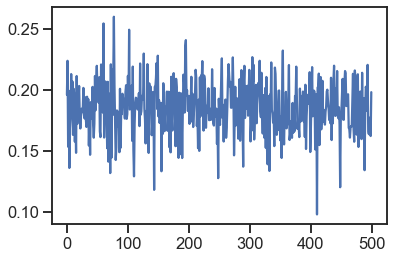

In [251]:
fig, ax = plt.subplots()
ax.plot(np.arange(500), Dtheta)

Mean: 18.514815718770944 +-: 0.19162028794748354


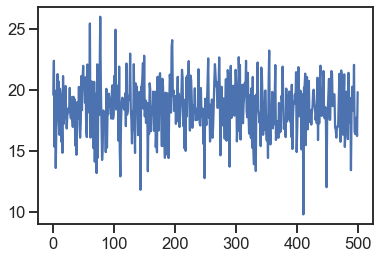

In [252]:
nabla_mean = np.array(Dtheta).mean()/delta
nablda_std = np.array(Dtheta).std()/delta
print("Mean:", nabla_mean, "+-:", 1.96 * nablda_std / np.sqrt(replications))
plt.plot(np.array(Dtheta)/delta)

Put this FD estimator procedure into a function

In [273]:
def finite_difference(delta, replications, starts_0, l=0, ratio_mh_o=0.5):
    """
    Estimate nabla/gradient using FD method.
    delta = difference in limit definition calculation (beware bias variance tradeoff).
    replications = # of independent cross reps.
    starts = a fixed starts sample path.
    l = fixed percentage single family homes.
    ratio_mh_o = ratio of low rise to mid high rise to estimate grad for
    """
    # fix CRN
    np.random.seed(Simr.seed)
    # inital values
    l = 0.0
    r_mh = ratio_mh_o # m/h
    lmh_init = np.array([l, (1-l)*r_mh, (1-l)*(1-r_mh)])
    print(lmh_init)
    #Simr.nlmh = lmh_init

    # set up the gradient for the ratio -> with this setup we only need to calculate delta on the one variable
    Dtheta = []
    r_mh_delta = r_mh+delta
    lmh_delta = np.array([l, (1-l)*r_mh_delta, (1-l)*(1-r_mh_delta)])
    print(lmh_delta)

    for i in range(0, replications):
        # simulation with initial values
        Simr.nlmh = lmh_init
        sim_out = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
        theta = np.array(sim_out['E_e'])*1e-9 + np.array(sim_out['E_o'])*1e-9
        theta = theta.sum()

        # Apply the FD method. Store the differences in Dtheta.
        Simr.nlmh = lmh_delta
        sim_out_d = Simr.chain_periods_build_lmh(years, starts_0, verbose=False)
        theta_d = np.array(sim_out_d['E_e'])*1e-9 + np.array(sim_out_d['E_o'])*1e-9
        theta_d = theta_d.sum()


        Dtheta.append(theta_d-theta)

    # calculate mean and std of diff
    fdmean = np.array(Dtheta).mean()/delta
    fdstd = np.array(Dtheta).std()/delta

    return fdmean, fdstd

In [256]:
years = np.arange(2023, 2040)
starts_0 = starts_data_hg10.loc[Simr.seed,'2023':'2050'].values.astype(int)
finite_difference(delta=0.01, replications=500, starts_0=starts_0, l=0, ratio_mh_o=0.5)

(18.514815718770944, 2.186101988360494)

Explore the gradient for ratio between 0-1 across different years. I use a high delta which increases bias, but bias here is not as big as a problem as variance if we know the entire gradient space. With delat = 0.01 and looking at 0, 0.125, 0.25, our gradient estimator looks at 0.126-0.125, 0.26-0.25. We expect it to be a smooth gradient so this big jumps should be a huge problem

In [274]:
years = np.arange(2023, 2040)
starts_0 = starts_data_hg10.loc[Simr.seed,'2023':'2050'].values.astype(int)

nablas2040 = []
for r in np.linspace(0,0.95,5):
    print(r)
    fd = finite_difference(delta=0.05, replications=50, starts_0=starts_0, l=0, ratio_mh_o=r)
    nablas2040.append(fd)

0.0
[0. 0. 1.]
[0.   0.05 0.95]
0.2375
[0.     0.2375 0.7625]
[0.     0.2875 0.7125]
0.475
[0.    0.475 0.525]
[0.    0.525 0.475]
0.7124999999999999
[0.     0.7125 0.2875]
[0.     0.7625 0.2375]
0.95
[0.   0.95 0.05]
[0. 1. 0.]


grad 18.582058070441274 +- 0.028253552319562204
grad 18.561291275769214 +- 0.03200596056213054
grad 18.55313584710651 +- 0.033698577490128646
grad 18.56203946488592 +- 0.03755068077595431
grad 18.551809718935594 +- 0.03991164071406418


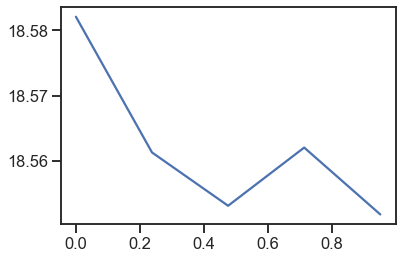

In [275]:
#print(np.array(nablas2040))
plt.plot(np.linspace(0,0.95,5), np.array(nablas2040)[:,0])

for i in range(5):
    print('grad',np.array(nablas2040)[i,0],'+-',1.96 * np.array(nablas2040)[i,1] / np.sqrt(replications))

In [271]:
nablas

[(0.418137922768695, 0.18650713024484009),
 (0.41943258531808547, 0.1720702747854273),
 (0.41838668375964666, 0.1584992579652472),
 (0.41713025285948074, 0.14195224365607081),
 (0.420438262955306, 0.12176959378359314),
 (0.42050558816496153, 0.09785844798171821)]

-------------------------------------------------------------------
### Attemping to optimize over three forms

In [ ]:
# fix CRN
np.random.seed(Simr.seed)

# fixed optimization vals
replications = 200
delta = 0.001
year = 2030
# choose some fixed housing growth
b_year = starts_data_hg10.loc[0,str(year)].astype(int)
b_year_cum = starts_data_hg10.loc[0,'2023':str(year)].values.sum().astype(int)

# inital values
lmh_init = np.array([0.4, 0.3, 0.3])
Simr.year = year
Simr.nlmh = lmh_init

# loop for estimating gradient
Dtheta = []
lmh_delta1 = lmh_init + np.array([delta, 0, 0])
lmh_delta2 = lmh_init + np.array([0, delta, 0])
lmh_delta3 = lmh_init + np.array([0, 0, delta])

for i in range(0, replications):
    #print('iter',i)

    # simulation with initial values
    Simr.nlmh = lmh_init
    print(Simr.nlmh)
    sim_out = Simr.single_year_simulation(b_year, b_year_cum)
    theta = (sim_out['E_e']*1e-9 + sim_out['E_o']*1e-9)

    # for each dimension, apply the FD method. Store the differences
    # in Dtheta.
    theta_dl = []
    for diff in [lmh_delta1, lmh_delta2, lmh_delta3]:
        Simr.nlmh = diff
        sim_out_d = Simr.single_year_simulation(b_year, b_year_cum)
        theta_d = (sim_out_d['E_e']*1e-9 + sim_out_d['E_o']*1e-9)

        theta_dl.append(theta_d)

    Dtheta.append([theta_dl[0]-theta ,theta_dl[1]-theta, theta_dl[2]-theta])

In [ ]:
nabla_mean = np.array(Dtheta).mean(axis=0)/delta
nablda_std = np.array(Dtheta).std(axis=0)/delta
print("Mean:", nabla_mean, "+-:", 1.96 * nablda_std / np.sqrt(replications))

Now we can store this in a function that will estimate calculate the gradient for any value passed to it. We have constraints on this problem; namely that L M H belong to [0,1] and L + M + H = 1. One hacky way of getting this constraint in gradient descent is to check these conditions each loop and apply a large penalty if they are not satisfied.

In [38]:
def finite_difference_lmh(delta, replications, lmh_0):
    """
    Estimate nabla gradient using FD method
    delta = difference in limit definition (bias variance tradeoff).
    replications = # of independent cross reps
    lmh_0 = lmh values for which to check gradient.
    """
    # fix CRN
    np.random.seed(Simr.seed)

    # loop for estimating gradient
    Dtheta = []
    lmh_delta1 = lmh_0 + np.array([delta, 0, 0])
    lmh_delta2 = lmh_0 + np.array([0, delta, 0])
    lmh_delta3 = lmh_0 + np.array([0, 0, delta])

    for i in range(0, replications):
        #print('iter',i)

        # simulation with initial values
        Simr.nlmh = lmh_0
        sim_out = Simr.single_year_simulation(b_year, b_year_cum)
        theta = (sim_out['E_e']*1e-9 + sim_out['E_o']*1e-9)

        # for each dimension, apply the FD method. Store the differences
        # in Dtheta.
        theta_dl = []
        for diff in [lmh_delta1, lmh_delta2, lmh_delta3]:
            Simr.nlmh = diff
            sim_out_d = Simr.single_year_simulation(b_year, b_year_cum)
            theta_d = (sim_out_d['E_e']*1e-9 + sim_out_d['E_o']*1e-9)

            theta_dl.append(theta_d)

        # append replication difference
        Dtheta.append([theta_dl[0]-theta ,theta_dl[1]-theta, theta_dl[2]-theta])

    # calculate mean and std of diff
    fdmean = np.array(Dtheta).mean(axis=0)/delta
    fdstd = np.array(Dtheta).std(axis=0)/delta

    return fdmean, fdstd

Develop the gradient descent algorithm

In [51]:
lmh_init
alpha=0.01

lmh_init - alpha*nabla

array([0.0185857 , 0.21255473, 0.22918863])